<a href="https://colab.research.google.com/github/pkonowrocki/Multiple-pixels-attack/blob/master/MultiplePixelsAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [0]:
#install required files
!pip3 install torch torchvision
!pip3 install matplotlib

file_id = '1Iz4CTYuTT-_eS1HrIU410VkeomP5dl0R'

#authentication
from google.colab import auth
auth.authenticate_user()

#build Gdrive service
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

try:
  import io
  from googleapiclient.http import MediaIoBaseDownload

  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
  downloaded.seek(0)
  print('Downloaded file')
  import pickle
  dataset = pickle.load(downloaded)
  assert type(dataset)!="<class 'dict'>", "Something went wrong with downloading file"
  print("Dataset ready")
  
  from urllib.request import urlopen
  idx2label = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl') )
  print("Labels ready")

except:
  print("Something wrong with file")
  print("Trying to download the file and upload it to a Gdrive")
  #downloading dataset
  !curl http://ml.cs.tsinghua.edu.cn/~chenxi/dataset/val224_compressed.pkl --output val224_compressed.pkl
    
  #mounting Gdrive 
  from google.colab import drive
  drive.mount('/content/gdrive')
  #upload dataset to Gdrive
  from googleapiclient.http import MediaFileUpload
  file_metadata = {
    'name': 'val224_compressed'
  }
  media = MediaFileUpload('val224_compressed.pkl',
                        resumable=True)
  created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
  print('File ID: {}'.format(created.get('id')))

Downloaded file
Dataset ready
Labels ready


In [0]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

import torchvision.models as models
net = models.shufflenet_v2_x1_0(pretrained=True).to(device)
net.eval()

print("Network ready")

cuda:0


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 9218294/9218294 [00:00<00:00, 40998233.86it/s]


Network ready


In [0]:
#find positive examples
import numpy as np
import cv2
import torch
import torch.nn as nn

def _str2img(str_b):
    return cv2.imdecode(np.frombuffer(str_b, np.uint8), cv2.IMREAD_COLOR)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

print("Got "+str(len(dataset["target"])) +" samples")
m = nn.Softmax()
positive = []

for i in range(len(dataset["target"])):
  image = _str2img(dataset["data"][i])
  image = torch.from_numpy(image).view(1, 3, 224, 224).to(device=device, dtype=torch.float)
  image.div_(255.)
  image[:, 0, :, :].sub_(mean[0]).div_(std[0])
  image[:, 1, :, :].sub_(mean[1]).div_(std[1])
  image[:, 2, :, :].sub_(mean[2]).div_(std[2])
  target = dataset["target"][i]
  output = net(image)
  output = m(output)
  values, indices = torch.max(output, 1)
  if(target==indices.item()):
    print("Image #"+str(i)+"\tprobability: "+str(values.item()*100))
    positive.append((i, values.item()*100))

print(positive)

Got 50000 samples


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Image #125	probability: 31.756043434143066


KeyboardInterrupt: ignored

# Implementation from paper

In [0]:
import numpy as np

PIXELS_COUNT = 5


class Individual:

    def __init__(self, code):
        self.code = code
        self.obj_fun_value = None

    @staticmethod
    def from_params(x, y, distortion):
        code = np.zeros((PIXELS_COUNT, 5), dtype=float)
        code[:, 0] = x
        code[:, 1] = y
        code[:, 2:5] = distortion
        return Individual(code)

    def get_mutant(self, population, f_param):
        r1, r2, r3 = [ind.code for ind in np.random.choice(population, 3, replace=False)]
        mutant_code = r1 + f_param * (r2 + r3)
        return Individual(mutant_code)

    def crossover_with(self, mutant, c_r, c_p, c_rgb):
        crossover_result = np.zeros((PIXELS_COUNT, 5), dtype=float)
        if np.random.rand() < c_p:
            crossover_result[:, 0:2] = self._crossover(
                self.code[:, 0:2], mutant.code[:, 0:2], c_r)
        if np.random.rand() < c_rgb:
            crossover_result[:, 2:5] = self._crossover(
                self.code[:, 2:5], mutant.code[:, 2:5], c_r)
        return Individual(crossover_result)

    def _crossover(self, first, second, c_r):
        return self._binomial_crossover(
            first,
            self._expotential_crossover(first, second),
            c_r
        )

    def _expotential_crossover(self, first, second):
        result = second
        start = np.random.randint(0, PIXELS_COUNT)
        end = np.random.randint(start, PIXELS_COUNT)
        result[start: end + 1, :] = first[start: end + 1, :]
        return result

    def _binomial_crossover(self, first, second, c_r):
        result = second
        for i in range(PIXELS_COUNT):
            if np.random.rand() < c_r:
                result[i, :] = first[i, :]
        return result
    
    def show_image(self, num_from_dataset):
        import matplotlib.pyplot as plt
        im = np.array(_str2img(dataset["data"][num_from_dataset]), dtype='int32')
        for i in range(self.code.shape[0]):
            im[int(self.code[(i,0)]), int(self.code[(i,1)])] += np.int32(self.code[i,2:5])  
        plt.title(idx2label[dataset["target"][num_from_dataset]])
        plt.imshow(im)
        plt.show()
        
print("Individual loaded")

Individual loaded


In [0]:
import numpy as np
from itertools import product
#from individual import Individual

PIXELS_COUNT = 5


class Population:
    """
    Class representing population of individuals

    """

    def __init__(self, iteration, cardinality, image_size, c_p, c_rgb, c_r, f_param, individuals=None):
        self.iteration = iteration
        self.cardinality = cardinality
        self.image_size = image_size
        self.c_p = c_p
        self.c_rgb = c_rgb
        self.c_r = c_r
        self.f_param = f_param

        if individuals == None:
            self.individuals = self._initialize_individuals(
                cardinality, image_size)
        else:
            self.individuals = individuals

    def _initialize_individuals(self, cardinality, image_size):
        individuals = []
        height, width = image_size
        possible_positions = np.array(
            list(product(range(height), range(width))))
        positions = possible_positions[np.random.randint(0,
                                                         height * width, cardinality * PIXELS_COUNT)]

        for i in range(cardinality):
            code = np.zeros((PIXELS_COUNT, 5))
            code[:, 2:5] = np.random.normal(128, 127, (PIXELS_COUNT, 3))
            code[:, 0:2] = positions[i * PIXELS_COUNT: i *
                                     PIXELS_COUNT + PIXELS_COUNT]
            individuals.append(Individual(code))
            i += 1

        return individuals

    def generate_next(self, objective_function):
        new_individuals = []
        for i in range(self.cardinality):
            parent = self.individuals[i]
            mutant = parent.get_mutant(
                self.individuals, self.f_param)
            descendant = parent.crossover_with(
                mutant, self.c_r, self.c_p, self.c_rgb)
            self._fix_individual(descendant)
            descendant.obj_fun_value = objective_function(descendant)
            
            if parent.obj_fun_value == None:
                parent.obj_fun_value = objective_function(parent)
              
            if descendant.obj_fun_value >= parent.obj_fun_value:
                new_individuals.append(descendant)
            else:
                new_individuals.append(parent)
            i += 1
        return Population(self.iteration + 1, self.cardinality, self.image_size, self.c_p, self.c_r, self.c_rgb, self.f_param, new_individuals)
      
    def get_best_individual(self):
      return self.individuals[np.argmax([ind.obj_fun_value for ind in self.individuals])]
    
    def _fix_individual(self, individual):
      height, width = self.image_size
      individual.code[:,0] = np.clip(individual.code[:,0], 0, height - 1)
      individual.code[:,1] = np.clip(individual.code[:,1], 0, width - 1)

In [0]:
import torch.nn as nn
import numpy as np
import cv2
import torch


#softmax layer to normalize output
m = nn.Softmax()

#mean and std of input normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#convert str to image
def _str2img(str_b):
    return cv2.imdecode(np.frombuffer(str_b, np.uint8), cv2.IMREAD_COLOR)

def find_probabilities(individual, num_from_dataset):
    im = np.array(_str2img(dataset["data"][num_from_dataset]), dtype='float64')
    for i in range(individual.code.shape[0]):
        im[int(individual.code[(i,0)]), int(individual.code[(i,1)])] += individual.code[i,2:5]          
    im = torch.from_numpy(im).view(1, 3, 224, 224).to(device=device, dtype=torch.float)
    im.div_(255.)
    im[:, 0, :, :].sub_(mean[0]).div_(std[0])
    im[:, 1, :, :].sub_(mean[1]).div_(std[1])
    im[:, 2, :, :].sub_(mean[2]).div_(std[2])
    output = net(im)
    return m(output)
  
def find_best_class(individual, num_from_dataset):
    output = find_probabilities(individual, num_from_dataset)
    values, indices = torch.max(output, 1)
    return values.item(), indices.item()
  
def fitness_function(individual, num_from_dataset):
    output = find_probabilities(individual, num_from_dataset)
    return output.cpu().detach().numpy()[0, dataset["target"][num_from_dataset]]
  
print("Fitness function loaded")

Fitness function loaded


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.98336095
0.9756546


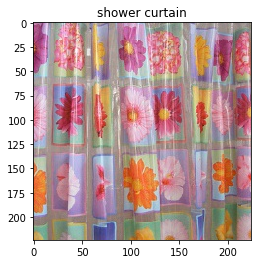

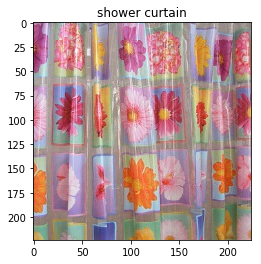

In [0]:
#test individual
first_of_its_kind = Individual.from_params(100,100,[90,-90,-80])
how_fit = fitness_function(first_of_its_kind, 27600)
print(how_fit)

second_of_its_kind = Individual.from_params(100,100,[0,0,0])
how_fit = fitness_function(second_of_its_kind, 27600)
print(how_fit)

first_of_its_kind.show_image(27600)
second_of_its_kind.show_image(27600)
#we can pretty much do it by hand XD

In [0]:
def differential_evolution(iter_count, population_cardinality, image_size, num_from_dataset, c_r, c_p, c_rgb, f_param):
  population = Population(0, population_cardinality, image_size, c_p, c_rgb, c_r, f_param)
  objective_function = lambda individual: 1 - fitness_function(individual, num_from_dataset)
  
  for i in range(iter_count):
    print("ITERATION: {0}".format(i))
    population = population.generate_next(objective_function)
    
  return population.get_best_individual()

ITERATION: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4
ITERATION: 5
ITERATION: 6
ITERATION: 7
ITERATION: 8
ITERATION: 9
ITERATION: 10
ITERATION: 11
ITERATION: 12
ITERATION: 13
ITERATION: 14
ITERATION: 15
ITERATION: 16
ITERATION: 17
ITERATION: 18
ITERATION: 19
ITERATION: 20
ITERATION: 21
ITERATION: 22
ITERATION: 23
ITERATION: 24
ITERATION: 25
ITERATION: 26
ITERATION: 27
ITERATION: 28
ITERATION: 29
ITERATION: 30
ITERATION: 31
ITERATION: 32
ITERATION: 33
ITERATION: 34
ITERATION: 35
ITERATION: 36
ITERATION: 37
ITERATION: 38
ITERATION: 39
ITERATION: 40
ITERATION: 41
ITERATION: 42
ITERATION: 43
ITERATION: 44
ITERATION: 45
ITERATION: 46
ITERATION: 47
ITERATION: 48
ITERATION: 49
ITERATION: 50
ITERATION: 51
ITERATION: 52
ITERATION: 53
ITERATION: 54
ITERATION: 55
ITERATION: 56
ITERATION: 57
ITERATION: 58
ITERATION: 59
ITERATION: 60
ITERATION: 61
ITERATION: 62
ITERATION: 63
ITERATION: 64
ITERATION: 65
ITERATION: 66
ITERATION: 67
ITERATION: 68
ITERATION: 69
ITERATION: 70
ITERATION: 71
ITERATION: 72
I

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


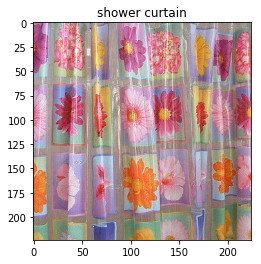

Image classified as shower curtain with probability 0.813496470451355


In [0]:
fooled = differential_evolution(100, 100, (224,224),27600, 0.5,0.5,0.5,0.1)
fooled.show_image(27600)
probability, label_index = find_best_class(fooled, 27600)
print("Image classified as {0} with probability {1}".format(idx2label[label_index], probability))

# New implementation

In [0]:
import numpy as np

class Individual:

    def __init__(self, code):
        self.code = code
        self.fitness = None
        
    @staticmethod
    def from_params(x, y, d, distortion):
        code = {}
        code[(x, y, d)] = distortion
        return Individual(code)
    
    def __add__(self, o):
        result = {}
        k1 = set(self.code.keys()) - set(o.code.keys())
        k2 = set(o.code.keys()) - set(self.code.keys())
        intersection = set(self.code.keys()) & set(o.code.keys())
        for k in intersection:
            result[k] = self.code[k] + o.code[k]
        for k in k1:
            result[k] = self.code[k]
        for k in k2:
            result[k] = o.code[k]
        return Individual(result)

    def __sub__(self, o):
        result = {}
        k1 = set(self.code.keys()) - set(o.code.keys())
        k2 = set(o.code.keys()) - set(self.code.keys())
        intersection = set(self.code.keys()) & set(o.code.keys())
        for k in intersection:
            result[k] = self.code[k] - o.code[k]
        for k in k1:
            result[k] = self.code[k]
        for k in k2:
            result[k] = o.code[k]
        return Individual(result)

    def __rmul__(self, o):
        result = {}
        for k in self.code.keys():
            result[k] = o*self.code[k]
        return Individual(result)
    
    def __mul__(self, o):
        result = {}
        for k in o.code.keys():
            result[k] = self*o.code[k]
        return Individual(result)
    
    def get_mutant(self, population, f_param):
        r1, r2, r3 = np.random.choice(population, 3, replace=False)
        mutant = r1 + f_param * (r2 + r3)
        return mutant

    def crossover_with(self, mutant, c_r):
        result = {}
        for k in mutant.code.keys():
            if c_r > np.random.rand():
                result[k] = mutant.code[k]
        
        for k in self.code.keys():
            if c_r > np.random.rand():
                if k in result.keys():
                    result[k] += self.code[k]
                else:
                    result[k] = self.code[k]
        
        return Individual(result)
    
    def show_image(self, num_from_dataset):
        import matplotlib.pyplot as plt
        im = np.array(_str2img(dataset["data"][num_from_dataset]), dtype='int32')
        for (k,v) in self.code.items():
            im[k] += v   
        plt.title(idx2label[dataset["target"][num_from_dataset]])
        plt.imshow(im)
        plt.show()
        
    def show_output(self, num_from_dataset):
        import matplotlib.pyplot as plt
        im = np.array(_str2img(dataset["data"][num_from_dataset]), dtype='float64')
        for (k,v) in self.code.items():
            im[k] += v          
        img = torch.from_numpy(im).view(1, 3, 224, 224).to(device=device, dtype=torch.float)
        img.div_(255.)
        img[:, 0, :, :].sub_(mean[0]).div_(std[0])
        img[:, 1, :, :].sub_(mean[1]).div_(std[1])
        img[:, 2, :, :].sub_(mean[2]).div_(std[2])
        output = net(img)
        output = m(output)
        value, indice = torch.max(output, 1)
        plt.title(idx2label[indice.item()])
        plt.imshow(im.astype(int))
        plt.show()
        
print("Individual loaded")

Individual loaded


In [0]:
import numpy as np
from itertools import product

class Population:
    """
    Class representing population of individuals

    """

    def __init__(self, iteration, cardinality, image_size, c_r, f_param, individuals=None):
        self.iteration = iteration
        self.cardinality = cardinality
        self.image_size = image_size
        self.c_r = c_r
        self.f_param = f_param

        if individuals == None:
            self.individuals = self._initialize_individuals(
                cardinality, image_size)
        else:
            self.individuals = individuals

    def _initialize_individuals(self, cardinality, image_size):
        individuals = []
        height, width = image_size
        
        for _ in range(cardinality):
            x = np.random.randint(width)
            y = np.random.randint(height)
            d = np.random.randint(3)
            disortion = np.random.randn()*5
            code = {}
            code[(x, y, d)] = disortion
            individuals.append(Individual.from_params(x,y,d,disortion))

        return individuals

    def generate_next(self, objective_function):
        new_individuals = []
        for i in range(self.cardinality):
            parent = self.individuals[i]
            mutant = parent.get_mutant(
                self.individuals, self.f_param)
            descendant = parent.crossover_with(
                mutant, self.c_r)
            descendant.fitness = objective_function(descendant)
            
            if parent.fitness == None:
                parent.fitness = objective_function(parent)
              
            if descendant.fitness <= parent.fitness:
                new_individuals.append(descendant)
            else:
                new_individuals.append(parent)
            i += 1
        return Population(self.iteration + 1, self.cardinality, self.image_size, self.c_r, self.f_param, new_individuals)
      
    def get_best_individual(self):
      return self.individuals[np.argmax([ind.fitness for ind in self.individuals])]
    
print("Population loaded")

Population loaded


In [0]:
import torch.nn as nn
import numpy as np
import cv2
import torch


#softmax layer to normalize output
m = nn.Softmax()

#mean and std of input normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#convert str to image
def _str2img(str_b):
    return cv2.imdecode(np.frombuffer(str_b, np.uint8), cv2.IMREAD_COLOR)


def fitness_function(individual, num_from_dataset):
    im = np.array(_str2img(dataset["data"][num_from_dataset]), dtype='float64')
    for (k,v) in individual.code.items():
        im[k] += v          
    im = torch.from_numpy(im).view(1, 3, 224, 224).to(device=device, dtype=torch.float)
    im.div_(255.)
    im[:, 0, :, :].sub_(mean[0]).div_(std[0])
    im[:, 1, :, :].sub_(mean[1]).div_(std[1])
    im[:, 2, :, :].sub_(mean[2]).div_(std[2])
    output = net(im)
    output = m(output)
    return output.cpu().detach().numpy()[0, dataset["target"][num_from_dataset]]
  
print("Fitness function loaded")

Fitness function loaded


In [0]:
def differential_evolution(iter_count, population_cardinality, image_size, num_from_dataset, c_r, f_param):
  population = Population(0, population_cardinality, image_size, c_r, f_param)
  objective_function = lambda individual: fitness_function(individual, num_from_dataset)
  
  for i in range(iter_count):
    offspring = population.generate_next(objective_function)
    print("Iteration: " + str(i) +"\tbest fitness value: "+str(population.get_best_individual().fitness))
    population = offspring
    
  return population.get_best_individual()

print("Differential evolution algorithm loaded")

Differential evolution algorithm loaded


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 0	best fitness value: 0.31845003
Iteration: 1	best fitness value: 0.31798765
Iteration: 2	best fitness value: 0.3176731
Iteration: 3	best fitness value: 0.31764892
Iteration: 4	best fitness value: 0.31753573
Iteration: 5	best fitness value: 0.31738696
Iteration: 6	best fitness value: 0.31707063
Iteration: 7	best fitness value: 0.31613743
Iteration: 8	best fitness value: 0.31522402
Iteration: 9	best fitness value: 0.31384906
Iteration: 10	best fitness value: 0.309828
Iteration: 11	best fitness value: 0.3065536
Iteration: 12	best fitness value: 0.3065536
Iteration: 13	best fitness value: 0.3065536
Iteration: 14	best fitness value: 0.30049393
Iteration: 15	best fitness value: 0.30049393
Iteration: 16	best fitness value: 0.30049393
Iteration: 17	best fitness value: 0.2962203
Iteration: 18	best fitness value: 0.2962203
Iteration: 19	best fitness value: 0.28931916
Iteration: 20	best fitness value: 0.27630553
Iteration: 21	best fitness value: 0.27630553
Iteration: 22	best fitness v

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 29	best fitness value: 1.00446226e-28


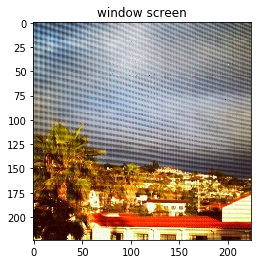

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


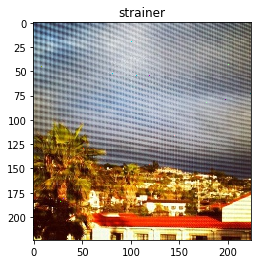

In [20]:
fooled = differential_evolution(30, 40, (224,224), 125, 0.5, 0.8)
fooled.show_image(125)
fooled.show_output(125)

Sources: [Dataset](https://github.com/aaron-xichen/pytorch-playground) [Neural network model](https://pytorch.org/docs/stable/torchvision/models.html)